In [2]:
import numpy as np
import pandas as pd

import pickle

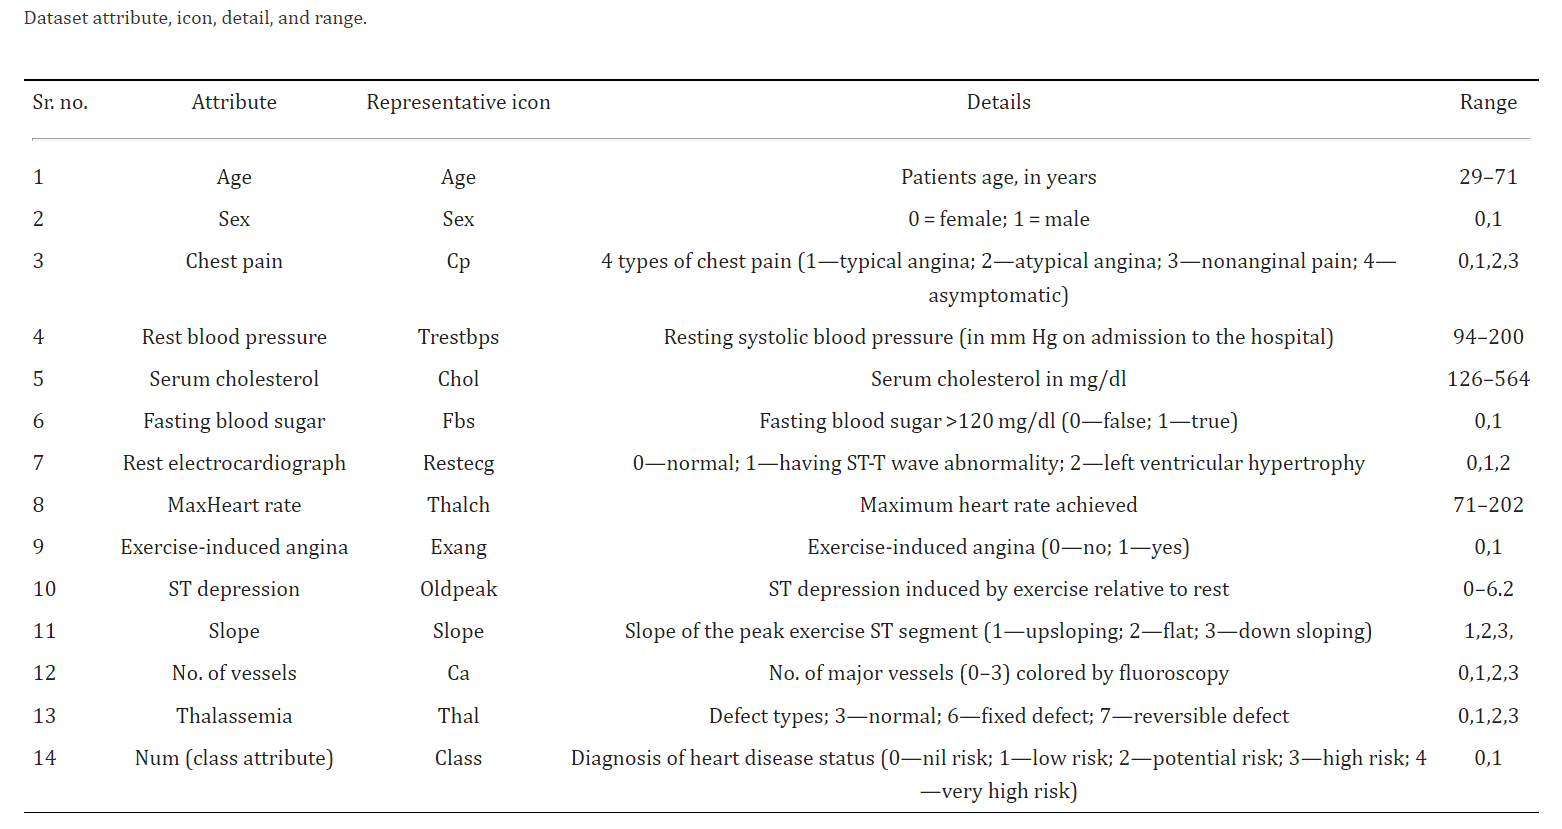

In [4]:
data = pd.read_csv('data/processed_cleveland.csv')

print(f'Number of rows: {data.shape[0]}')
print(f'Number of features: {data.shape[1]}')

categorical = ['sex', 'cp', 'restecg', 'slope', 'thal']
do_not_touch = ['fbs', 'exang']
non_categorical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

data.head()

Number of rows: 297
Number of features: 14


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [21]:
data.mode(axis=0)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,58.0,1.0,4.0,120.0,197,0.0,0.0,162.0,0.0,0.0,1.0,0.0,3.0,0.0
1,NaN,NaN,NaN,NaN,234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [63]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [6]:
def change_target(target):
    if target > 0:
        return 1
    return 0

data['num'] = data['num'].map(change_target)



In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer

In [8]:
X, y = data.drop('num', axis=1), data['num']

In [9]:
random_state = 42
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

scaler = StandardScaler()
encoder = OneHotEncoder()

encoder_ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical)], remainder='passthrough')
X_gd = pd.DataFrame(encoder_ct.fit_transform(X))

with open('models/encoder.pkl', 'wb') as f:
    pickle.dump(encoder_ct, f)

In [10]:
clf = SVC(probability=True, random_state=random_state)

pipeline = make_pipeline(StandardScaler(), clf)

parameters = [{'svc__kernel': ['rbf'],
               'svc__C': [1, 10, 100, 1000],
               'svc__gamma': [1, 0.1, 0.001, 0.0001],
            },
            {'svc__kernel': ['poly'],
               'svc__C': [1, 10, 100, 1000],
               'svc__gamma': [1, 0.1, 0.001, 0.0001],
             'svc__degree': range(1, 5)}
             ]

svm_gs = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    scoring='f1',
    cv=folds,
    verbose=True
)

svm_gs.fit(X_gd, y)

svm_clf = svm_gs.best_estimator_

Fitting 10 folds for each of 80 candidates, totalling 800 fits


In [11]:
clf = LogisticRegression(random_state=random_state)

pipeline = make_pipeline(StandardScaler(), clf)

parameters = {'logisticregression__C': [1, 10, 100, 1000]}

lr_gs = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    scoring='f1',
    cv=folds,
    verbose=True
)

lr_gs.fit(X_gd, y)

lr_clf = lr_gs.best_estimator_

Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [12]:
random_state = 42
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

random_forest = RandomForestClassifier(class_weight={0: 0.45, 1:0.55}, random_state=random_state)
params_dict = {'n_estimators': [i for i in range(100, 600, 50)],
              'max_depth': [2, 3, 4, 5],
              'min_samples_split': [i for i in range(2, 10)],
              'min_samples_leaf': [i for i in range(1, 7)],
              'criterion': ['gini', 'entropy']}

rf_rs = RandomizedSearchCV(random_forest, params_dict, random_state=random_state, scoring='f1', cv=folds, n_jobs=-1,
                        n_iter=500, verbose=2)
rf_rs.fit(X, y)

rf_clf = rf_rs.best_estimator_

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


In [13]:
clf = KNeighborsClassifier()

pipeline = make_pipeline(StandardScaler(), clf)

parameters = {'kneighborsclassifier__n_neighbors': [i for i in range(1, 15)]}

knn_gs = GridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    scoring='f1',
    cv=folds,
    verbose=True
)

knn_gs.fit(X_gd, y)

knn_clf = knn_gs.best_estimator_

Fitting 10 folds for each of 14 candidates, totalling 140 fits


In [14]:
def save_model(model, name, fold):
    with open(f'models/{name}_fold_{fold}.pkl', 'wb') as f:
        pickle.dump(model, f)


knn_oof_array = np.empty_like(y, dtype='float64')
svm_oof_array = np.empty_like(y, dtype='float64')
lr_oof_array = np.empty_like(y, dtype='float64')
rf_oof_array = np.empty_like(y, dtype='float64')


for index, (train_idx, val_idx) in enumerate(folds.split(X, y), 1):
    X_train = X.loc[train_idx, :]
    y_train = y[train_idx]
    X_val = X.loc[val_idx, :]
    y_val = y[val_idx]
    X_train_gd = X_gd.loc[train_idx, :]
    X_val_gd = X_gd.loc[val_idx, :]
    
    knn_clf.fit(X_train_gd, y_train)
    svm_clf.fit(X_train_gd, y_train)
    lr_clf.fit(X_train_gd, y_train)
    rf_clf.fit(X_train, y_train)
    
    knn_oof = knn_clf.predict_proba(X_val_gd)[:, 1]
    svm_oof = svm_clf.predict_proba(X_val_gd)[:, 1]
    lr_oof = lr_clf.predict_proba(X_val_gd)[:, 1]
    rf_oof = rf_clf.predict_proba(X_val)[:, 1]
    
    save_model(knn_clf, 'knn', index)
    save_model(svm_clf, 'svm', index)
    save_model(lr_clf, 'logistic_regression', index)
    save_model(rf_clf, 'random_forest', index)
    
    knn_oof_array[val_idx] = knn_oof
    svm_oof_array[val_idx] = svm_oof
    lr_oof_array[val_idx] = lr_oof
    rf_oof_array[val_idx] = rf_oof

In [15]:
knn_oof_array = knn_oof_array.reshape((-1, 1))
svm_oof_array = svm_oof_array.reshape((-1, 1))
lr_oof_array = lr_oof_array.reshape((-1, 1))
rf_oof_array = rf_oof_array.reshape((-1, 1))


oof_array = np.concatenate((knn_oof_array, svm_oof_array, lr_oof_array, rf_oof_array), axis=1)

In [16]:
oofs = pd.DataFrame(oof_array, columns=['knn', 'svm', 'logistic_regression', 'random_forest'])

In [17]:
logistic_regression = LogisticRegression(random_state=random_state)
logistic_regression.fit(oofs, y)

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

prediction_proba = logistic_regression.predict_proba(oofs)[:, 1]
prediction = logistic_regression.predict(oofs)

In [18]:
acc = accuracy_score(y, prediction)
recall = recall_score(y, prediction)
precision = precision_score(y, prediction)
f1 = f1_score(y, prediction)

print(f'Accuracy: {acc}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'f1-score: {f1}')

Accuracy: 0.8383838383838383
Recall: 0.7956204379562044
Precision: 0.8449612403100775
f1-score: 0.8195488721804511


In [19]:
with open('models/stacking_logistic_regression.pkl', 'wb') as f:
    pickle.dump(logistic_regression, f)